In [1]:
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, accuracy_score,
    precision_score, recall_score, f1_score
)

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)


In [2]:
# Load data
application_df = pd.read_csv("..\\Dataset\\application_record.csv")
credit_df = pd.read_csv("..\\Dataset\\credit_record.csv")

# Labeling based on credit status
def label_credit_status(df):
    bad_status = {'2', '3', '4', '5'}
    df['bad_credit'] = df['STATUS'].isin(bad_status).astype(int)
    return df.groupby('ID')['bad_credit'].max().reset_index()

# Generate labels
credit_labels = label_credit_status(credit_df)

# Merge with application data
data = application_df.merge(credit_labels, on='ID')

# Preprocessing

# Drop ID column
X = data.drop(columns=['ID', 'bad_credit'])
y = data['bad_credit']

# Encode categorical features
label_enc = LabelEncoder()
for col in X.select_dtypes(include='object').columns:
    X[col] = label_enc.fit_transform(X[col].astype(str))

# Train-test and split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Dictionary of models
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=50, use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42)
}


===== Logistic Regression =====

 Best Threshold for Logistic Regression: 0.36 (F1 = 0.0376)


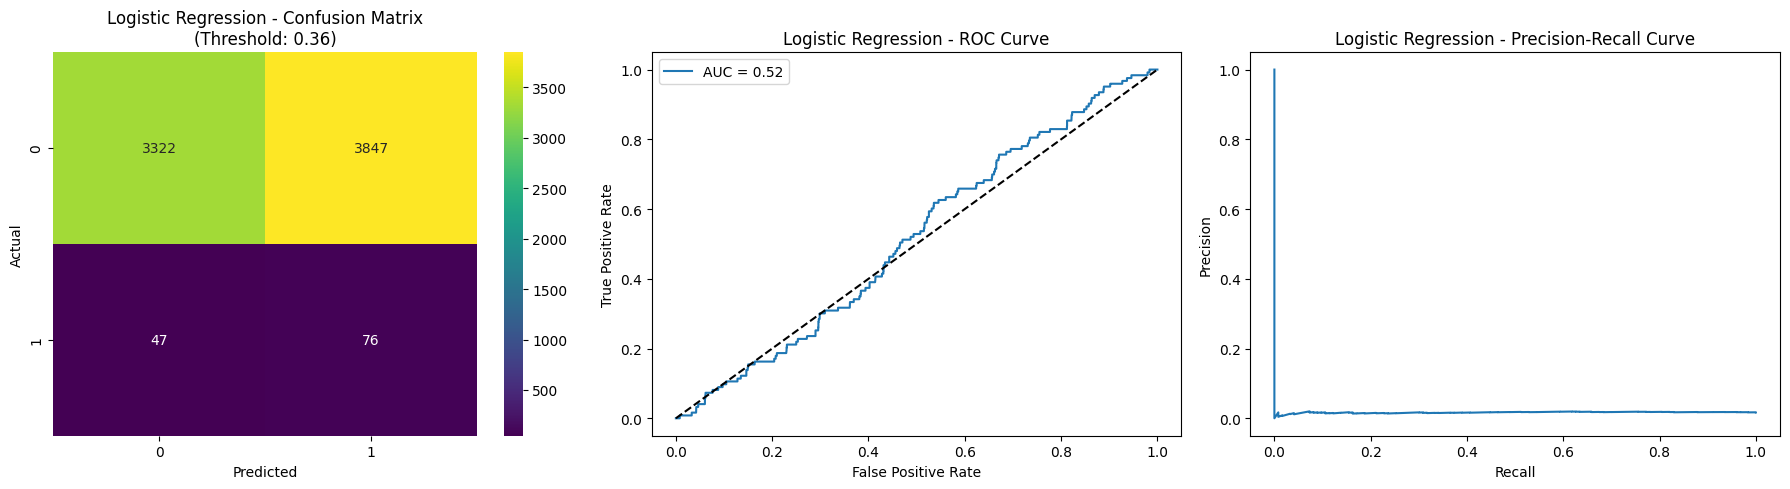


===== Random Forest =====

 Best Threshold for Random Forest: 0.34 (F1 = 0.2827)


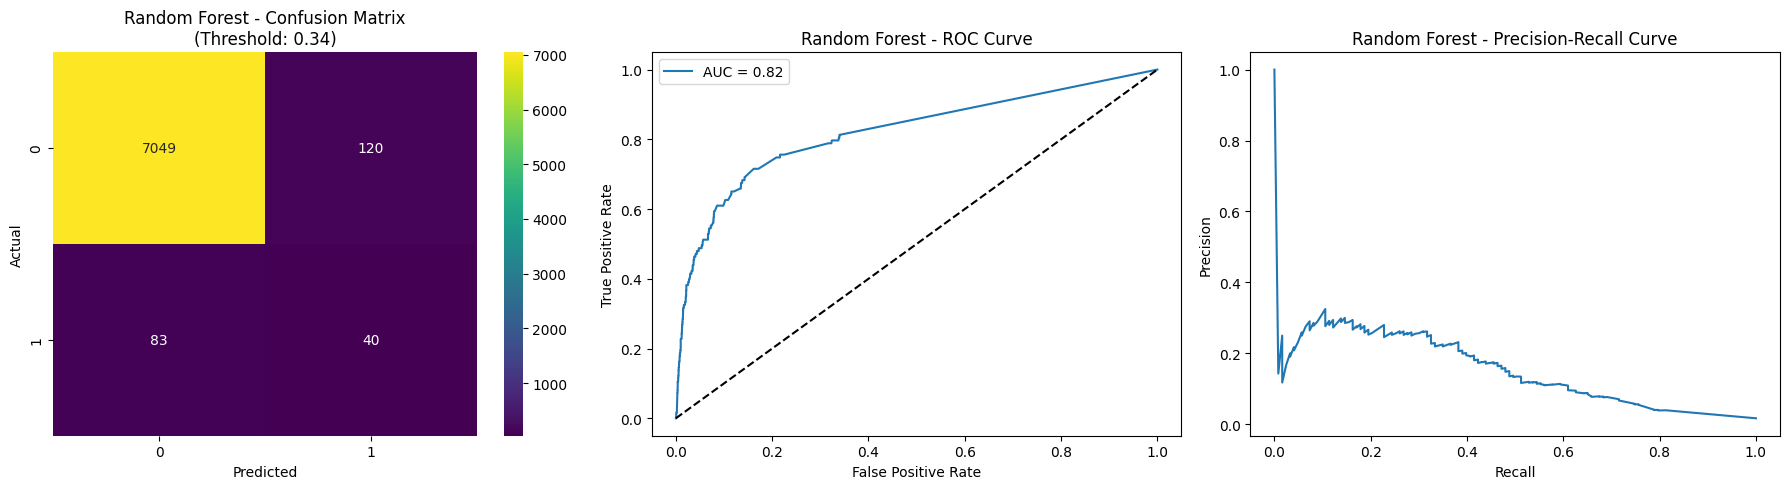


===== XGBoost =====

 Best Threshold for XGBoost: 0.93 (F1 = 0.2308)


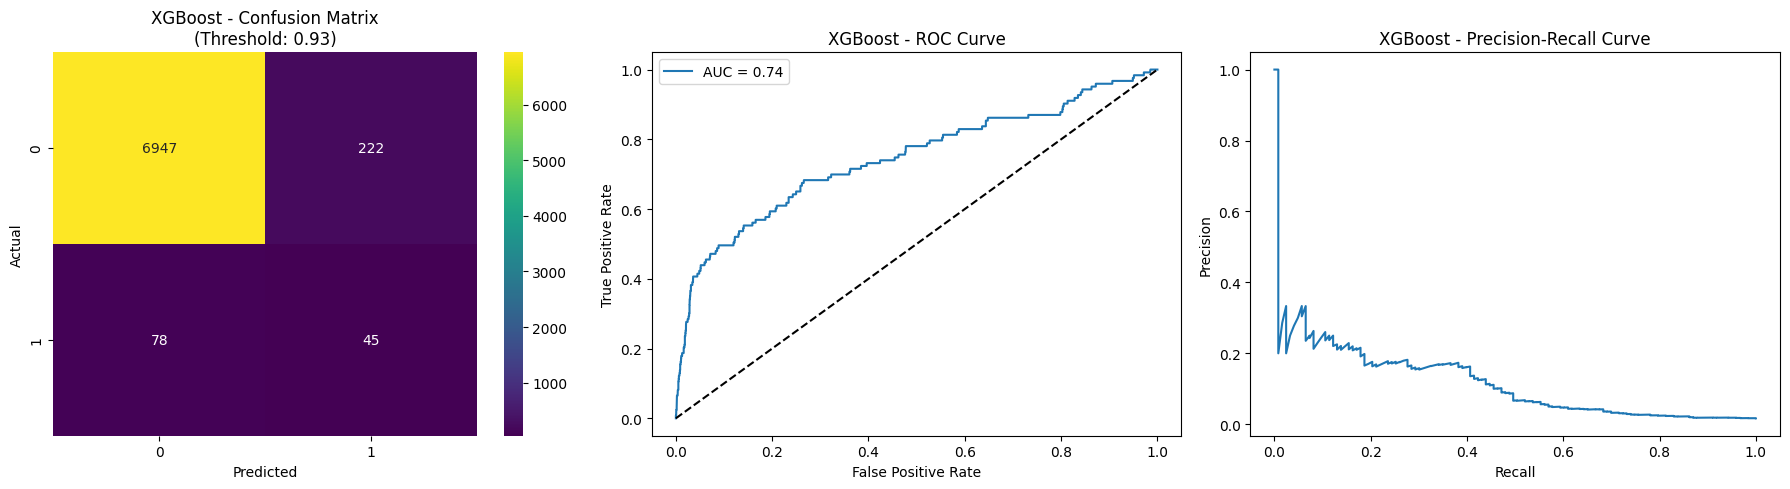


===== Decision Tree =====

 Best Threshold for Decision Tree: 0.17 (F1 = 0.2788)


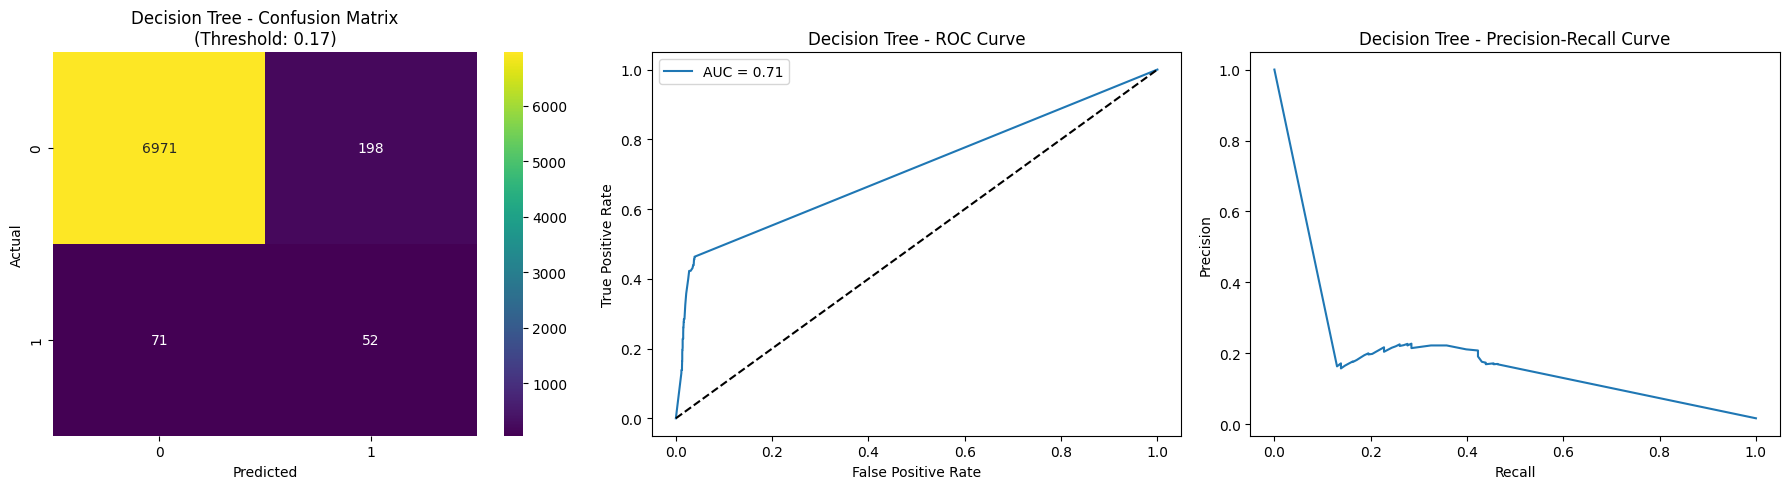


Model Comparison Summary:
                 Model  Threshold  Accuracy  Precision    Recall  F1 Score  \
1        Random Forest       0.34  0.972161   0.250000  0.325203  0.282686   
3        Decision Tree       0.17  0.963110   0.208000  0.422764  0.278820   
2              XGBoost       0.93  0.958859   0.168539  0.365854  0.230769   
0  Logistic Regression       0.36  0.465990   0.019373  0.617886  0.037568   

    ROC AUC  
1  0.820050  
3  0.713799  
2  0.744721  
0  0.517148  


In [3]:
# Store results for all models
results = []

# Train and evaluate each model
for name, model in models.items():
    print(f"\n===== {name} =====")

    # Train the model
    model.fit(X_resampled, y_resampled)
    
    # Predict probabilities
    y_proba = model.predict_proba(X_test)[:, 1]

    # --- Loop to compute metrics at each threshold ---
    thresholds = np.linspace(0, 1, 100)
    precision_list = []
    recall_list = []
    f1_list = []

    # print("Threshold\tPrecision\tRecall\t\tF1 Score")
    for thresh in thresholds:
        y_thresh_pred = (y_proba >= thresh).astype(int)
        p = precision_score(y_test, y_thresh_pred, zero_division=0)
        r = recall_score(y_test, y_thresh_pred, zero_division=0)
        f = f1_score(y_test, y_thresh_pred, zero_division=0)

        precision_list.append(p)
        recall_list.append(r)
        f1_list.append(f)
        # print(f"{thresh:.2f}\t\t{p:.4f}\t\t{r:.4f}\t\t{f:.4f}")

    # Find the best threshold (max F1)
    best_idx = np.argmax(f1_list)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_list[best_idx]

    print(f"\n Best Threshold for {name}: {best_threshold:.2f} (F1 = {best_f1:.4f})")

    # Final predictions using best threshold
    y_pred_thresh = (y_proba >= best_threshold).astype(int)

    # Final metrics at best threshold
    acc = accuracy_score(y_test, y_pred_thresh)
    prec = precision_score(y_test, y_pred_thresh)
    rec = recall_score(y_test, y_pred_thresh)
    auc = roc_auc_score(y_test, y_proba)

    # Save model results
    results.append({
        "Model": name,
        "Threshold": round(best_threshold, 2),
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": best_f1,
        "ROC AUC": auc
    })

    # --- Plots ---
    cm = confusion_matrix(y_test, y_pred_thresh)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)

    plt.figure(figsize=(18, 5))

    # Confusion Matrix
    plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
    plt.title(f'{name} - Confusion Matrix\n(Threshold: {best_threshold:.2f})')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # ROC Curve
    plt.subplot(1, 3, 2)
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{name} - ROC Curve')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()

    # Precision-Recall Curve
    plt.subplot(1, 3, 3)
    plt.plot(recall_curve, precision_curve)
    plt.title(f'{name} - Precision-Recall Curve')
    plt.xlabel("Recall")
    plt.ylabel("Precision")

    plt.tight_layout()
    
    #  Save the plot
    output_folder = "../Images"  

    os.makedirs(output_folder, exist_ok=True)

    plot_path = os.path.join(output_folder, f"{name}_plot.png")

    plt.savefig(plot_path)
    plt.show()
    plt.close()

# Show summary of all models
results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
print("\nModel Comparison Summary:")
print(results_df)


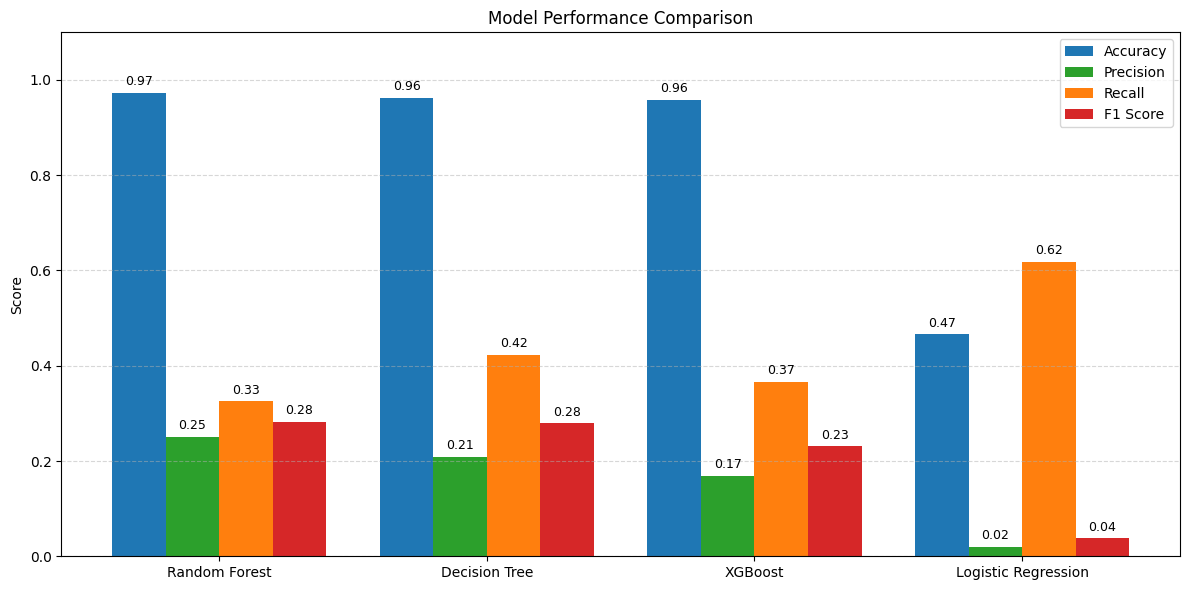

In [4]:
# Metrics to plot
metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1 Score"]
bar_width = 0.2
colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']

# Model names
models = results_df["Model"].values
x = np.arange(len(models))  

# Plotting
plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics_to_plot):
    scores = results_df[metric].values
    positions = x + i * bar_width
    plt.bar(positions, scores, width=bar_width, label=metric, color=colors[i])

    # Add text on top of bars
    for j, val in enumerate(scores):
        plt.text(positions[j], val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9)

# Setup x-axis
plt.xticks(x + bar_width * 1.5, models, rotation=0)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.ylim(0, 1.1)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Save the plot
os.makedirs("../Images", exist_ok=True)
plt.savefig("../Images/model_comparison_metrics.png")

# Show plot
plt.show()


In [5]:
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=50, use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42)
}
model_folder = "../models"
os.makedirs(model_folder, exist_ok=True)

# Identify the best model by F1 Score
best_model_name = results_df.iloc[0]['Model']
best_threshold = results_df.iloc[0]['Threshold']

# Re-train the best model (recommended)
best_model = models[best_model_name]
best_model.fit(X_resampled, y_resampled)

# Save the model
model_path = os.path.join(model_folder, f"{best_model_name.replace(' ', '_')}_best_model.pkl")
joblib.dump(best_model, model_path)

# Save the best threshold
threshold_path = os.path.join(model_folder, "best_threshold.txt")
with open(threshold_path, "w") as f:
    f.write(str(best_threshold))

# Save training columns (optional but useful for future prediction)
train_columns_path = os.path.join(model_folder, "train_columns.pkl")
joblib.dump(X_resampled.columns.tolist(), train_columns_path)

# Output summary
print(f"\n Best model saved to: {model_path}")
print(f"Best threshold saved to: {threshold_path}")
print(f"Training feature columns saved to: {train_columns_path}")



 Best model saved to: ../models\Random_Forest_best_model.pkl
Best threshold saved to: ../models\best_threshold.txt
Training feature columns saved to: ../models\train_columns.pkl


In [6]:
application_df.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS'],
      dtype='object')

In [10]:
X.columns

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS'],
      dtype='object')

In [11]:
X.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,1,1,1,0,427500.0,4,1,0,4,-12005,-4542,1,1,0,0,18,2.0
1,1,1,1,0,427500.0,4,1,0,4,-12005,-4542,1,1,0,0,18,2.0
2,1,1,1,0,112500.0,4,4,1,1,-21474,-1134,1,0,0,0,16,2.0
3,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,1,0,1,1,14,1.0
4,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,1,0,1,1,14,1.0
